# Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random
import xgboost as xgb
from mlxtend.plotting import plot_decision_regions

plt.style.use('ggplot')
%matplotlib inline
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

In [2]:
from sklearn import datasets, metrics
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, accuracy_score, f1_score, fbeta_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

df = pd.read_csv('./diabetes.csv')

In [3]:
del df['Unnamed: 0']

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,diag_1,diag_2,diag_3,number_diagnoses,change,readmitted
0,72091308,20123568,Caucasian,Female,75,NaN,1,22,7,58,2,15,injury and poisoning,"endocrine, nutritional and metabolic diseases,...",diseases of the blood and blood-forming organs,9,Ch,NO
1,72848634,20377854,Caucasian,Female,65,NaN,2,1,3,59,3,11,external causes of injury and supplemental cla...,diseases of the circulatory system,diseases of the genitourinary system,6,No,NO
2,73062156,20408121,Caucasian,Female,95,NaN,1,1,4,56,1,9,diseases of the digestive system,diseases of the circulatory system,diseases of the digestive system,6,No,NO
3,73731852,20542797,Caucasian,Male,75,NaN,1,2,10,68,1,18,diseases of the skin and subcutaneous tissue,diseases of the circulatory system,"endocrine, nutritional and metabolic diseases,...",6,Ch,NO
4,80820942,20514150,Caucasian,Female,65,NaN,2,1,4,33,0,11,diabetes-related,diseases of the circulatory system,diseases of the circulatory system,4,Ch,<30


In [5]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                          int64
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
change                      object
readmitted                  object
dtype: object

The `readmitted` column currently contains three categorical values for whether a patient is readmitted. We'll simplify the values in the column and designate 0 to mean not readmitted and 1 to signify readmitted.

In [6]:
df['readmitted'].replace({'NO':0, '>30':1, '<30':1}, inplace=True)
df['readmitted'].value_counts()

0    31019
1     8706
Name: readmitted, dtype: int64

Let's also look at a heatmap to get an idea of which features are more closely correlated in order to choose predictor variables for our model.

<AxesSubplot:>

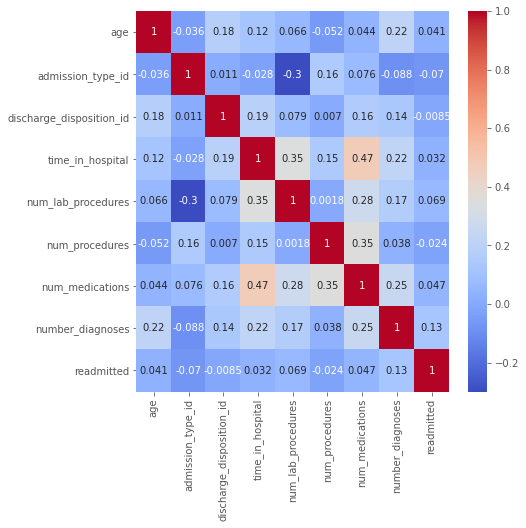

In [7]:
df1 = df[['age', 'admission_type_id', 'discharge_disposition_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'readmitted']]

plt.figure(figsize=(7, 7))
sns.heatmap(df1.corr(), cmap='coolwarm', annot=True)

### Variable Pre-Processing

We'll pre-process data using the following steps:
1. Split the data into train, test, and validation sets.
2. One-hot encode categorical variables for each set.
3. Standardize continous variables for each set.
4. Combine the processed features into a dataframe.

In [8]:
#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, label_train, label_test = train_test_split(df[['race', 'gender', 'age', 'time_in_hospital',
                                                                'num_lab_procedures', 'num_procedures', 'num_medications',
                                                                'diag_1', 'diag_2', 'diag_3']], df['readmitted'],
                                                            test_size=0.2, random_state=2018)
X_train, X_val, label_train, label_val = train_test_split(df[['race', 'gender', 'age', 'time_in_hospital',
                                                              'num_lab_procedures', 'num_procedures', 'num_medications',
                                                              'diag_1', 'diag_2', 'diag_3']], df['readmitted'],
                                                          test_size=0.25, random_state=2019)

In [9]:
# Select categorical variables from training set
cat_variable = ['race', 'gender', 'diag_1', 'diag_2', 'diag_3']

X_train_cat = X_train[cat_variable]

In [10]:
# Instantiate OneHotEncoder object
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, drop='first')
ohe.fit(X_train_cat) 
cats = ohe.transform(X_train_cat)

In [11]:
# Create categorial dataframe with column names
columns = ohe.get_feature_names(cat_variable)
X_train_cat_df = pd.DataFrame(cats, columns=columns, index=X_train_cat.index)
X_train_cat_df.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,diag_1_congenital anomalies,diag_1_diabetes-related,diag_1_diseases of the blood and blood-forming organs,diag_1_diseases of the circulatory system,diag_1_diseases of the digestive system,...,diag_3_diseases of the nervous system and sense organs,diag_3_diseases of the respiratory system,diag_3_diseases of the skin and subcutaneous tissue,"diag_3_endocrine, nutritional and metabolic diseases, and immunity disorders",diag_3_external causes of injury and supplemental classification,diag_3_infectious and parasitic diseases,diag_3_injury and poisoning,diag_3_mental disorders,diag_3_neoplasms,"diag_3_symptoms, signs, and ill-defined conditions"
32808,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17840,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20047,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
31796,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8831,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Repeat for test set
X_test_cat = X_test[['race', 'gender', 'diag_1', 'diag_2', 'diag_3']]

cats_test = ohe.transform(X_test_cat)

cat_columns = ohe.get_feature_names(['race', 'gender', 'diag_1', 'diag_2', 'diag_3'])
X_test_cat_df = pd.DataFrame(cats_test, columns=cat_columns, index=X_test_cat.index)
X_test_cat_df.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,diag_1_congenital anomalies,diag_1_diabetes-related,diag_1_diseases of the blood and blood-forming organs,diag_1_diseases of the circulatory system,diag_1_diseases of the digestive system,...,diag_3_diseases of the nervous system and sense organs,diag_3_diseases of the respiratory system,diag_3_diseases of the skin and subcutaneous tissue,"diag_3_endocrine, nutritional and metabolic diseases, and immunity disorders",diag_3_external causes of injury and supplemental classification,diag_3_infectious and parasitic diseases,diag_3_injury and poisoning,diag_3_mental disorders,diag_3_neoplasms,"diag_3_symptoms, signs, and ill-defined conditions"
12251,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
294,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27846,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24932,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12493,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Repeat for validation set
X_val_cat = X_val[['race', 'gender', 'diag_1', 'diag_2', 'diag_3']]

cats_val = ohe.transform(X_val_cat)

cat_columns = ohe.get_feature_names(['race', 'gender', 'diag_1', 'diag_2', 'diag_3'])
X_val_cat_df = pd.DataFrame(cats_val, columns=cat_columns, index=X_val_cat.index)
X_val_cat_df.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,diag_1_congenital anomalies,diag_1_diabetes-related,diag_1_diseases of the blood and blood-forming organs,diag_1_diseases of the circulatory system,diag_1_diseases of the digestive system,...,diag_3_diseases of the nervous system and sense organs,diag_3_diseases of the respiratory system,diag_3_diseases of the skin and subcutaneous tissue,"diag_3_endocrine, nutritional and metabolic diseases, and immunity disorders",diag_3_external causes of injury and supplemental classification,diag_3_infectious and parasitic diseases,diag_3_injury and poisoning,diag_3_mental disorders,diag_3_neoplasms,"diag_3_symptoms, signs, and ill-defined conditions"
25681,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10685,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12392,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39038,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Pre-process continous variables
X_train_cont = X_train[['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']]

X_train_cont.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications
32808,75,1,35,0,12
17840,75,1,29,6,15
20047,85,2,46,2,13
31796,35,1,48,0,10
8831,85,3,1,1,3


In [15]:
# Standardize continous variable
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications
32808,0.524942,-1.103291,-0.347399,-0.774528,-0.498613
17840,0.524942,-1.103291,-0.643103,2.760324,-0.126908
20047,1.167596,-0.758083,0.194724,0.403756,-0.374711
31796,-2.045670,-1.103291,0.293292,-0.774528,-0.746416
8831,1.167596,-0.412875,-2.023054,-0.185386,-1.613727


In [16]:
# Repeat for test set
X_test_cont = X_test[['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']]

X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications
12251,-0.760364,-1.103291,0.884699,0.403756,-0.126908
294,1.167596,-0.412875,-0.100980,-0.185386,-0.994219
27846,1.167596,3.039204,-1.825918,-0.774528,-0.003007
24932,-0.117711,0.622749,-0.445967,0.403756,0.120895
12493,-0.117711,-1.103291,0.244008,-0.774528,-0.994219


In [17]:
# Repeat for validation set
X_val_cont = X_val[['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']]

X_val_scaled = ss.transform(X_val_cont)

cont_columns = X_val_cont.columns
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=cont_columns, index=X_val_cont.index)

X_val_scaled_df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications
25681,0.524942,-0.067667,-0.593819,0.403756,0.120895
10685,1.167596,-0.412875,0.736847,-0.185386,-0.250810
12392,0.524942,-0.067667,0.293292,-0.185386,0.492599
23686,-0.760364,0.277541,0.786131,-0.185386,0.864304
39038,0.524942,-0.758083,0.933983,2.760324,0.492599


In [18]:
# Combine continous and categorical features for train set
X_train_combined = pd.concat([X_train_cat_df, X_train_scaled_df], axis='columns')

X_train_combined.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,diag_1_congenital anomalies,diag_1_diabetes-related,diag_1_diseases of the blood and blood-forming organs,diag_1_diseases of the circulatory system,diag_1_diseases of the digestive system,...,diag_3_infectious and parasitic diseases,diag_3_injury and poisoning,diag_3_mental disorders,diag_3_neoplasms,"diag_3_symptoms, signs, and ill-defined conditions",age,time_in_hospital,num_lab_procedures,num_procedures,num_medications
32808,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.524942,-1.103291,-0.347399,-0.774528,-0.498613
17840,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.524942,-1.103291,-0.643103,2.760324,-0.126908
20047,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.167596,-0.758083,0.194724,0.403756,-0.374711
31796,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,-2.045670,-1.103291,0.293292,-0.774528,-0.746416
8831,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.167596,-0.412875,-2.023054,-0.185386,-1.613727


In [19]:
# Repeat for test set
X_test_combined = pd.concat([X_test_cat_df, X_test_scaled_df], axis='columns')

X_test_combined.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,diag_1_congenital anomalies,diag_1_diabetes-related,diag_1_diseases of the blood and blood-forming organs,diag_1_diseases of the circulatory system,diag_1_diseases of the digestive system,...,diag_3_infectious and parasitic diseases,diag_3_injury and poisoning,diag_3_mental disorders,diag_3_neoplasms,"diag_3_symptoms, signs, and ill-defined conditions",age,time_in_hospital,num_lab_procedures,num_procedures,num_medications
12251,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.760364,-1.103291,0.884699,0.403756,-0.126908
294,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.167596,-0.412875,-0.100980,-0.185386,-0.994219
27846,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.167596,3.039204,-1.825918,-0.774528,-0.003007
24932,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.117711,0.622749,-0.445967,0.403756,0.120895
12493,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.117711,-1.103291,0.244008,-0.774528,-0.994219


In [20]:
# Repeat for validation set
X_val_combined = pd.concat([X_val_cat_df, X_val_scaled_df], axis='columns')

X_val_combined.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,diag_1_congenital anomalies,diag_1_diabetes-related,diag_1_diseases of the blood and blood-forming organs,diag_1_diseases of the circulatory system,diag_1_diseases of the digestive system,...,diag_3_infectious and parasitic diseases,diag_3_injury and poisoning,diag_3_mental disorders,diag_3_neoplasms,"diag_3_symptoms, signs, and ill-defined conditions",age,time_in_hospital,num_lab_procedures,num_procedures,num_medications
25681,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.524942,-0.067667,-0.593819,0.403756,0.120895
10685,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.167596,-0.412875,0.736847,-0.185386,-0.250810
12392,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.524942,-0.067667,0.293292,-0.185386,0.492599
23686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.760364,0.277541,0.786131,-0.185386,0.864304
39038,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.524942,-0.758083,0.933983,2.760324,0.492599


## KNN
Let's now fit our data to a kNN model and look at the accuracy, precision, and recall scores.

In [21]:
def print_accuracy(model, x_tr, y_tr, x_te, y_te):
    print("The accuracy score for {} is...".format(model))
    print("Training: {:6.2f}%".format(100*model.score(x_tr, y_tr)))
    print("Test set: {:6.2f}%".format(100*model.score(x_te, y_te)))

In [22]:
def precision_and_recall(y_te, y_pred, threshold=0.5):
    if threshold != 0.5:
        print("Threshold of {}...".format(threshold))
    else:
        print("Default threshold...")
    print("Precision: {:6.2f}%, Recall: {:6.2f}%".format(100*precision_score(y_te, y_pred, zero_division=0),
                                                      100*recall_score(y_te, y_pred, zero_division=0)))

In [23]:
def print_scores(model, x_tr, y_tr, x_te, y_te, y_pred, threshold=0.5):
    '''
    This function prints accuracy, precision, and recall scores for a given model
    '''
    
    print("The accuracy score for {} is...".format(model))
    print("Training: {:6.2f}%".format(100*model.score(x_tr, y_tr)))
    print("Test set: {:6.2f}%".format(100*model.score(x_te, y_te)))
    
    if threshold != 0.5:
        print("Threshold of {}...".format(threshold))
    else:
        print("Default threshold...")
    print("Precision: {:6.2f}%, Recall: {:6.2f}%".format(100*precision_score(y_te, y_pred, zero_division=0),
                                                      100*recall_score(y_te, y_pred, zero_division=0)))

In [24]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_combined, label_train)

print_accuracy(knn, X_train_combined, label_train, X_test_combined, label_test)

The accuracy score for KNeighborsClassifier() is...
Training:  80.31%
Test set:  78.64%


In [25]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = knn.predict(X_test_combined)
    
precision_and_recall(label_test, y_predict)

Default threshold...
Precision:  52.75%, Recall:  22.05%


In [26]:
# using the new threshold of 0.06
y_predict = (knn.predict_proba(X_test_combined)[:,1] > 0.06)

precision_and_recall(label_test, y_predict, 0.06)

Threshold of 0.06...
Precision:  29.43%, Recall:  93.55%


Let's look at the confusion matrix for our KNeighborsClassifier.

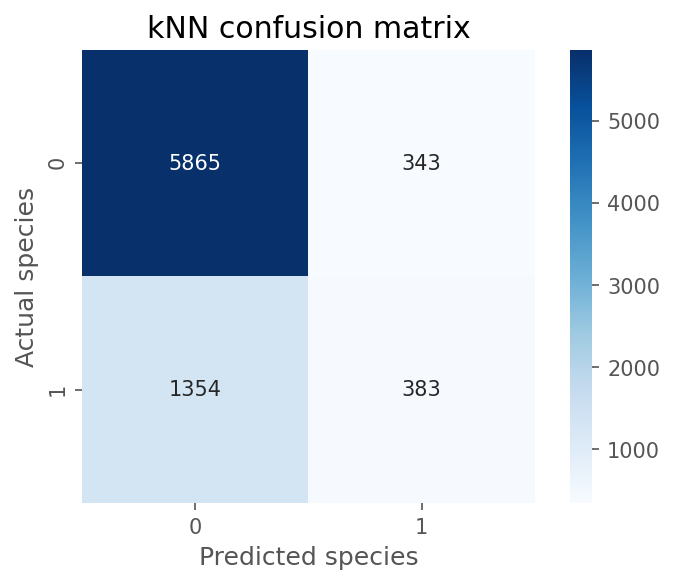

In [27]:
# Print confusion matrix for kNN
knn_confusion = confusion_matrix(label_test, knn.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=df['readmitted'].unique(),
           yticklabels=df['readmitted'].unique())

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('kNN confusion matrix');

### Random Oversampling
Given that there is a class imbalance for the `readmitted` target variable, we may be able to improve the model by utilizing random oversampling. 

In [28]:
df['readmitted'].value_counts()

0    31019
1     8706
Name: readmitted, dtype: int64

Before we move on to a different model, let's try to improve the current models by using random oversampling. We can see that there is a class imbalance in our target variable, so it's always going to be about as accurate as the imbalance itself. In other words, there are 31019 records classifying when a patient is not readmitted to the hospital and just 8706 when a patient is readmitted. That means 72% of the patients in our data aren't readmitted, so a classification model that predicts guesses "not readmitted" 72% of the time will be fairly accurate.

In [29]:
# Add some random oversampling of the minority classes
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train_combined, label_train)

In [30]:
# Yay, balanced classes!
Counter(y_resampled)

Counter({1: 23223, 0: 23223})

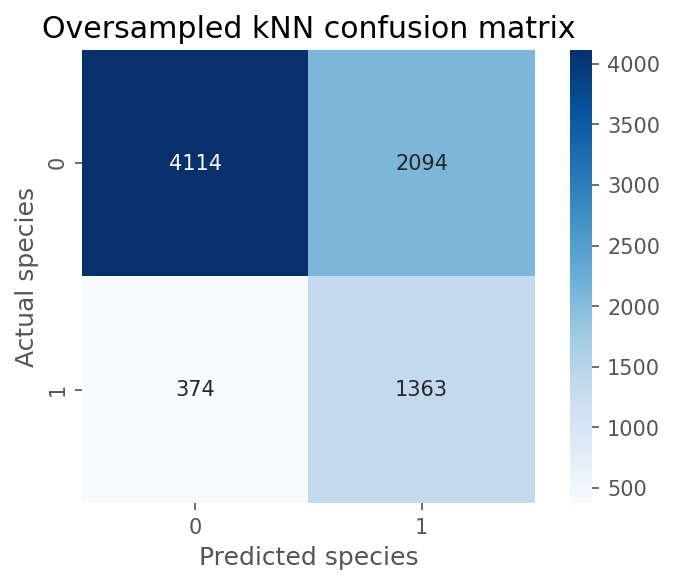

In [31]:
# Run the analysis again. What do we expect to see with balanced classes??
# cell takes ~15s to run
knn_resampled = KNeighborsClassifier()
clf_ros = knn_resampled.fit(X_resampled, y_resampled)

# Print confusion matrix for kNN regression
knn_resampled_confusion = confusion_matrix(label_test, knn_resampled.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(knn_resampled_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Oversampled kNN confusion matrix');

We'll look at the scores again for the resampled data.

In [32]:
print_accuracy(knn_resampled, X_resampled, y_resampled, X_test_combined, label_test)

The accuracy score for KNeighborsClassifier() is...
Training:  81.69%
Test set:  68.94%


In [33]:
precision_and_recall(label_test, knn_resampled.predict(X_test_combined))

Default threshold...
Precision:  39.43%, Recall:  78.47%


We can visualize the model performance by looking at the predicted probabilities.

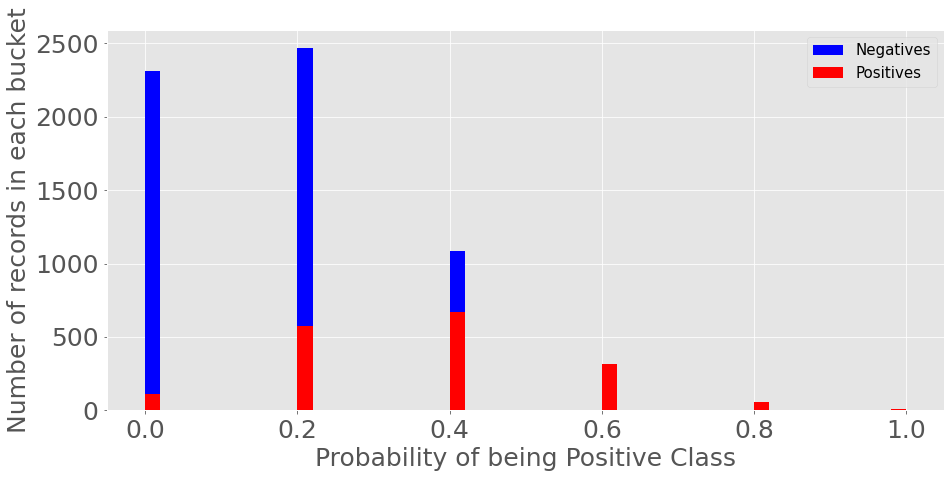

In [34]:
prediction = knn.predict_proba(X_test_combined)[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[label_test==0], bins=50, label='Negatives', color='b')
plt.hist(prediction[label_test==1], bins=50, label='Positives', color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

## Logistic Regression
Let's now look at the same information for the logistic regression model to compare. We'll look at the baseline model and then use random oversampling to see if we can improve, and then we'll look at the scores again.

In [35]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train_combined, label_train)

print_accuracy(logit, X_train_combined, label_train, X_test_combined, label_test)

The accuracy score for LogisticRegression(C=0.95) is...
Training:  77.95%
Test set:  78.14%


/Users/willnobles/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = logit.predict(X_test_combined)
    
precision_and_recall(label_test, y_predict)

Default threshold...
Precision:   0.00%, Recall:   0.00%


In [37]:
# using the new threshold of 0.06
y_predict = (logit.predict_proba(X_test_combined)[:,1] > 0.06)
    
precision_and_recall(label_test, y_predict, 0.06)

Threshold of 0.06...
Precision:  21.87%, Recall: 100.00%


Let's do a prediction using our Linear Regression model. We can see that the logistic regression model predicts an outcome of 0, or not readmitted, roughly 80% of the time and an outcome of 1, or readmitted, about 20% of the time.

In [38]:
prediction = logit.predict_proba(X_test_combined)
prediction

array([[0.77063255, 0.22936745],
       [0.80522247, 0.19477753],
       [0.83904928, 0.16095072],
       ...,
       [0.70079596, 0.29920404],
       [0.80570968, 0.19429032],
       [0.76522447, 0.23477553]])

We'll also look at the confusion matrix for the Logistic Regression model.

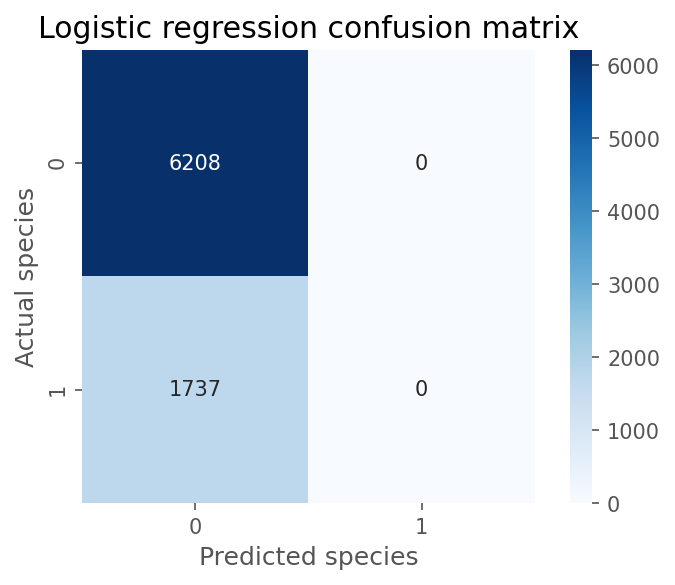

In [39]:
# Print confusion matrix for logistic regression
logit_confusion = confusion_matrix(label_test, logit.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Logistic regression confusion matrix');

Given that our categorical variables have a large number of classes, a logistic model will already be hard to interpret. If we find other models with less interpretability, but with better scores, we should go with that.

In [40]:
# Look at the logistic regression model coefficients
logit.coef_

array([[ 0.12627449,  0.46705323,  0.13487985,  0.31688638, -0.02022057,
        -0.35279585,  0.43072986,  0.58219735,  0.42192622,  0.29601687,
         0.1988694 ,  0.30050387,  0.2068949 ,  0.40634861,  0.35992953,
         0.29992073,  0.66678299,  0.30233561,  0.16435129,  0.37754695,
        -0.07757732,  0.42544149,  0.19186227,  0.19951953,  0.29640866,
         0.27905969,  0.22385277,  0.40816752,  0.46093712,  0.42705761,
         0.18678264,  0.5456821 ,  0.13021956,  0.47780036,  0.36469685,
         0.09694652,  0.18008212,  0.21744678,  0.03900015, -0.0233223 ,
         0.12558036,  0.35780014,  0.20881703,  0.18088812,  0.22803214,
         0.1863025 ,  0.10147356,  0.18646217,  0.41419134, -0.04451914,
         0.26736223,  0.20319735,  0.04320128,  0.11871948,  0.22635309,
         0.02981951,  0.04056865, -0.01233977,  0.14019644, -0.08768661,
         0.09359156]])

We'll try random oversampling or the LogisticRegression model like we did for our KNeighborsClassifier to see what improvements can be made.

/Users/willnobles/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


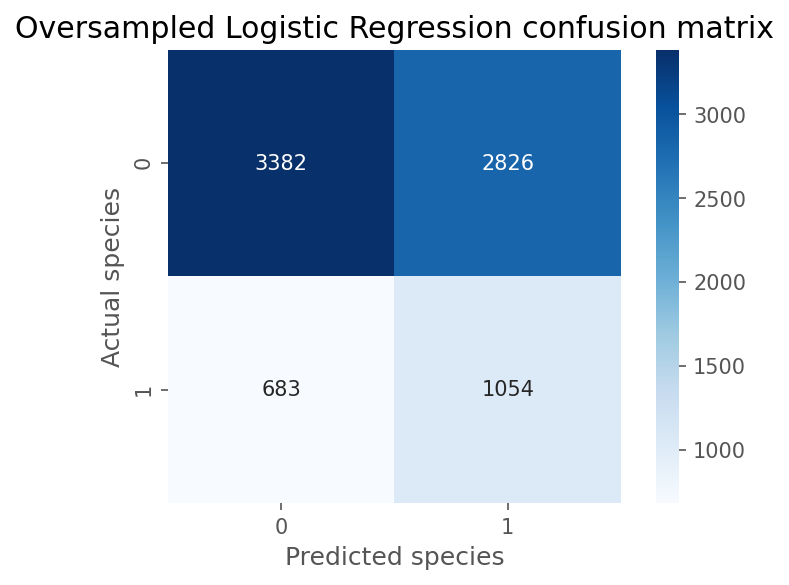

In [41]:
# Run the analysis again. What do we expect to see with balanced classes??
# cell takes ~15s to run
lr_resampled = LogisticRegression()
clf_ros = lr_resampled.fit(X_resampled, y_resampled)

# Print confusion matrix for kNN regression
lr_resampled_confusion = confusion_matrix(label_test, lr_resampled.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(lr_resampled_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Oversampled Logistic Regression confusion matrix');

The scores for the resampled logistic regression model don't seem like an improvement over the original.

In [42]:
print_accuracy(lr_resampled, X_resampled, y_resampled, X_test_combined, label_test)

The accuracy score for LogisticRegression() is...
Training:  57.40%
Test set:  55.83%


In [43]:
precision_and_recall(label_test, lr_resampled.predict(X_test_combined))

Default threshold...
Precision:  27.16%, Recall:  60.68%


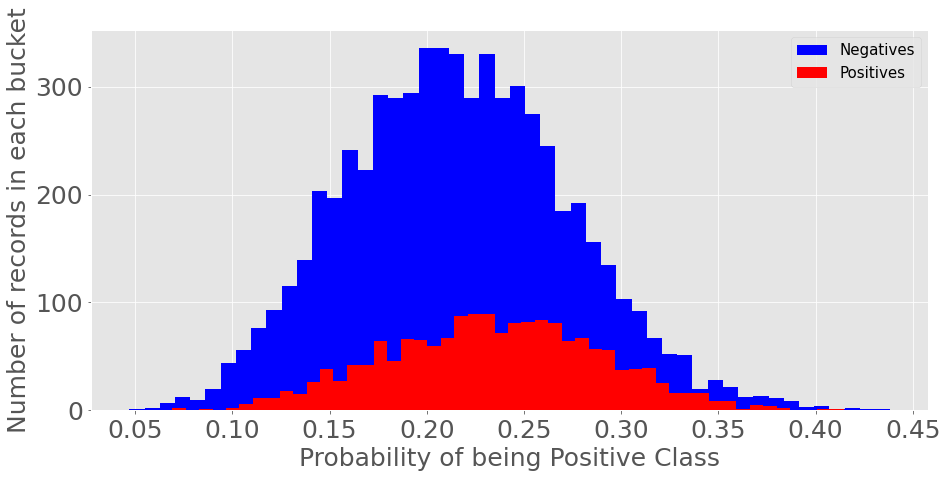

In [44]:
prediction = logit.predict_proba(X_test_combined)[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[label_test==0], bins=50, label='Negatives', color='b')
plt.hist(prediction[label_test==1], bins=50, label='Positives', color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

## Decision Tree

In [45]:
decisiontree = DecisionTreeClassifier(max_depth=4)
decisiontree.fit(X_train_combined, label_train)
y_pred = decisiontree.predict(X_test_combined)

print_scores(decisiontree, X_train_combined, label_train, X_test_combined, label_test, y_pred)

The accuracy score for DecisionTreeClassifier(max_depth=4) is...
Training:  77.95%
Test set:  78.14%
Default threshold...
Precision:   0.00%, Recall:   0.00%


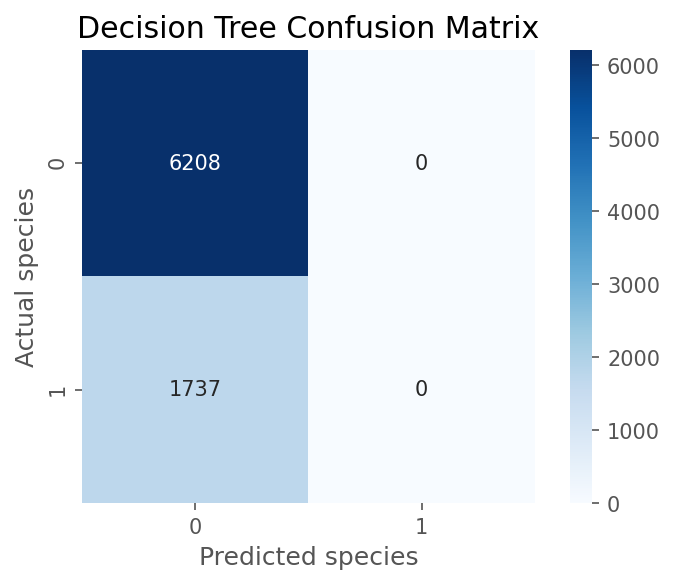

In [46]:
# Print confusion matrix for logistic regression
dt_confusion = confusion_matrix(label_test, decisiontree.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(dt_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Decision Tree Confusion Matrix');

### Oversampling

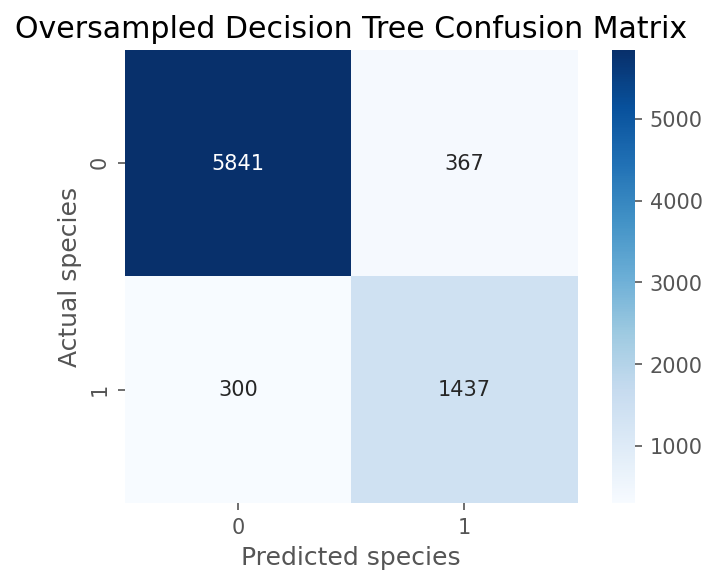

In [47]:
# Run the analysis again. What do we expect to see with balanced classes??
# cell takes ~15s to run
dt_resampled = DecisionTreeClassifier()
clf_ros = dt_resampled.fit(X_resampled, y_resampled)

# Print confusion matrix for kNN regression
dt_resampled_confusion = confusion_matrix(label_test, dt_resampled.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(dt_resampled_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Oversampled Decision Tree Confusion Matrix');

In [48]:
print_accuracy(dt_resampled, X_resampled, y_resampled, X_test_combined, label_test)

The accuracy score for DecisionTreeClassifier() is...
Training:  99.98%
Test set:  91.60%


In [49]:
precision_and_recall(label_test, dt_resampled.predict(X_test_combined))

Default threshold...
Precision:  79.66%, Recall:  82.73%


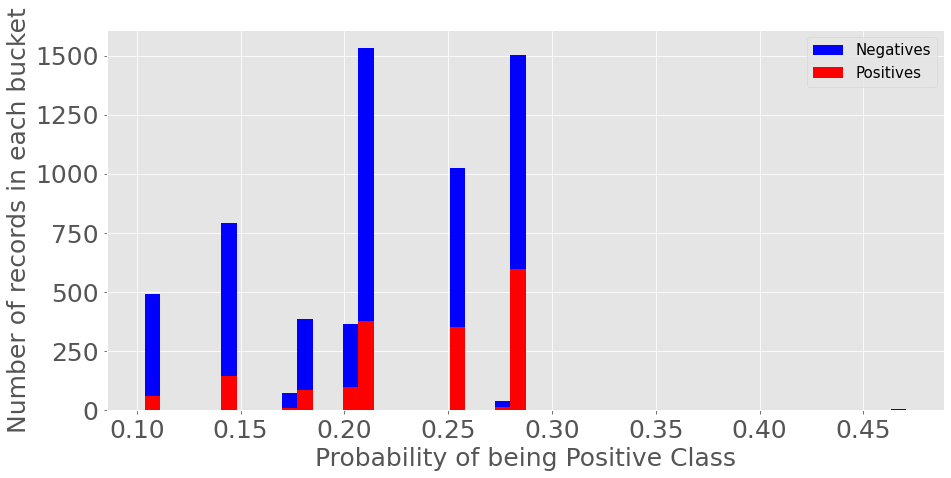

In [50]:
prediction = decisiontree.predict_proba(X_test_combined)[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[label_test==0], bins=50, label='Negatives', color='b')
plt.hist(prediction[label_test==1], bins=50, label='Positives', color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

## Random Forest
We'll first look at the scores for the model, and then we'll try oversampling and look at the scores again.

In [51]:
randomforest = RandomForestClassifier(n_estimators=100)
randomforest.fit(X_train_combined, label_train)
y_pred = randomforest.predict(X_test_combined)

print_scores(randomforest, X_train_combined, label_train, X_test_combined, label_test, y_pred)

The accuracy score for RandomForestClassifier() is...
Training:  99.98%
Test set:  94.64%
Default threshold...
Precision:  98.09%, Recall:  76.97%


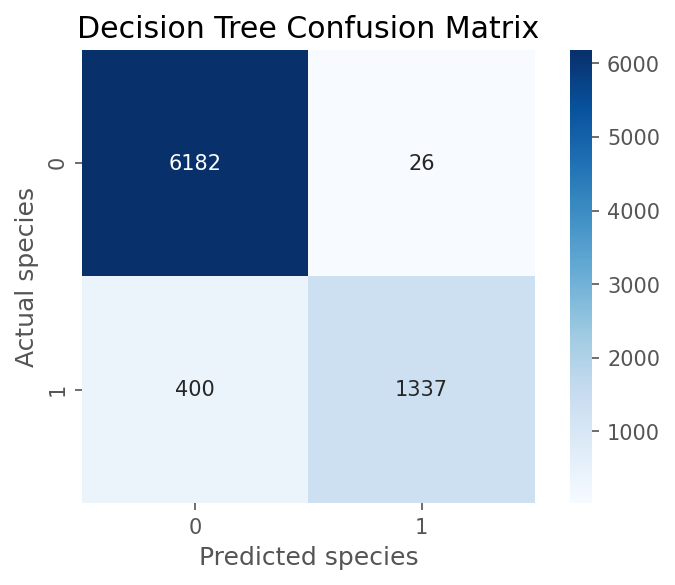

In [52]:
# Print confusion matrix for logistic regression
rf_confusion = confusion_matrix(label_test, randomforest.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Decision Tree Confusion Matrix');

### Oversampling

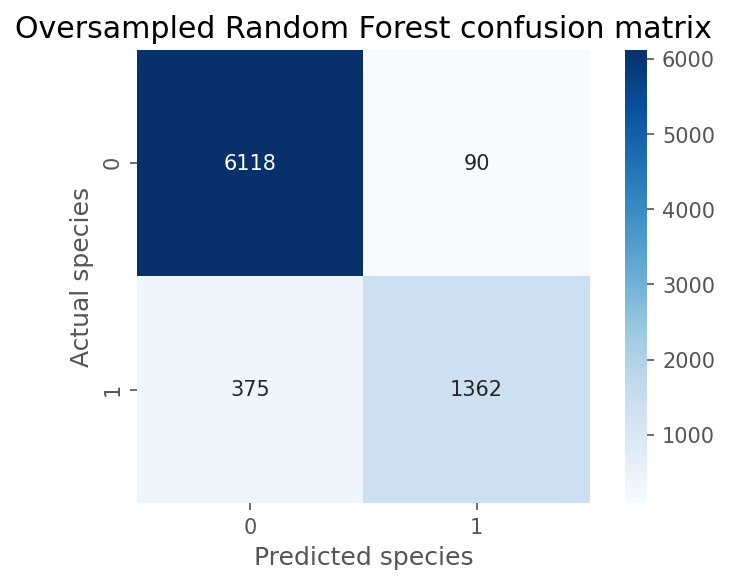

In [53]:
# Run the analysis again. What do we expect to see with balanced classes??
# cell takes ~15s to run
rf_resampled = RandomForestClassifier(n_estimators=100)
clf_ros = rf_resampled.fit(X_resampled, y_resampled)

# Print confusion matrix for kNN regression
rf_resampled_confusion = confusion_matrix(label_test, rf_resampled.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(rf_resampled_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Oversampled Random Forest confusion matrix');

In [54]:
print_accuracy(rf_resampled, X_resampled, y_resampled, X_test_combined, label_test)

The accuracy score for RandomForestClassifier() is...
Training:  99.98%
Test set:  94.15%


In [55]:
precision_and_recall(label_test, rf_resampled.predict(X_test_combined))

Default threshold...
Precision:  93.80%, Recall:  78.41%


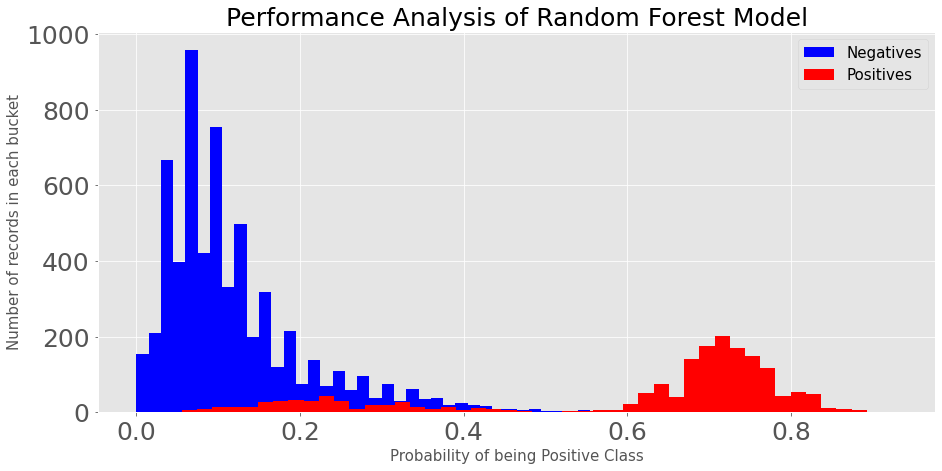

In [86]:
prediction = randomforest.predict_proba(X_test_combined)[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[label_test==0], bins=50, label='Negatives', color='b')
plt.hist(prediction[label_test==1], bins=50, label='Positives', color='r')
plt.xlabel('Probability of being Positive Class', fontsize=15)
plt.ylabel('Number of records in each bucket', fontsize=15)
plt.title('Performance Analysis of Random Forest Model', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

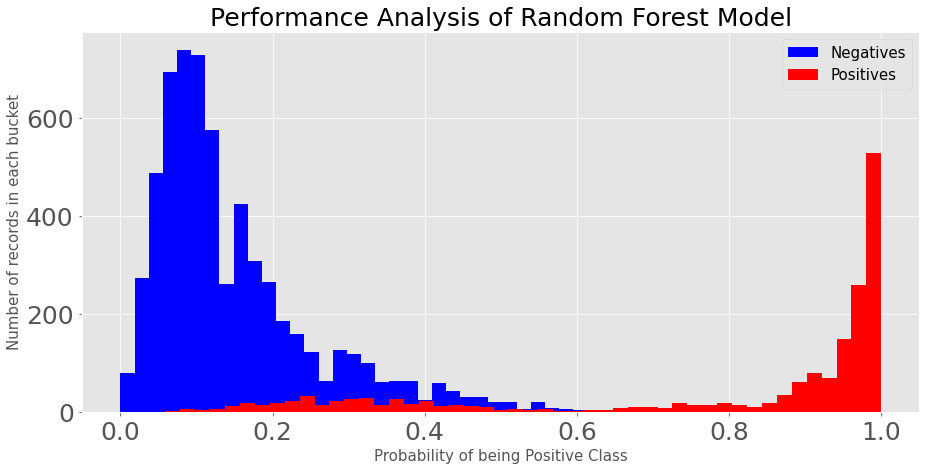

In [167]:
prediction = rf_resampled.predict_proba(X_test_combined)[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[label_test==0], bins=50, label='Negatives', color='b')
plt.hist(prediction[label_test==1], bins=50, label='Positives', color='r')
plt.xlabel('Probability of being Positive Class', fontsize=15)
plt.ylabel('Number of records in each bucket', fontsize=15)
plt.title('Performance Analysis of Random Forest Model', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

In [163]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    fi_df.reset_index(drop=True, inplace=True)
    
    # Filter out the top 20 indices in feature_importance column
    bottom_indices = fi_df[(fi_df['feature_importance'] < 0.01)].index

    # Delete these row indexes from DataFrame
    fi_df.drop(bottom_indices, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'Feature Importance', fontsize=25)
    plt.xlabel('Feature Importance', fontsize=15)
    plt.ylabel('Feature Name', fontsize=15)

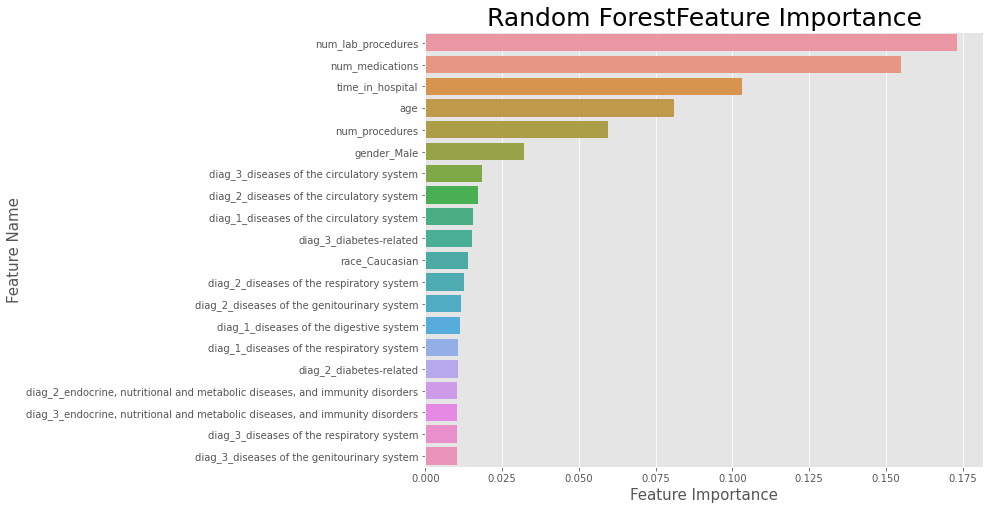

In [164]:
plot_feature_importance(rf_resampled.feature_importances_, X_resampled.columns, 'Random Forest')

## XGBoost

In [57]:
gbm = xgb.XGBClassifier( 
        n_estimators=30000,
        max_depth=4,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.05, 
        subsample=.8,
        min_child_weight=3,
        colsample_bytree=.8)

eval_set=[(X_train_combined, label_train), (X_val_combined, label_val)]

fit_model = gbm.fit(X_train_combined, label_train,
                    eval_set=eval_set, eval_metric='error',
                    early_stopping_rounds=50, verbose=False)

y_pred = gbm.predict(X_test_combined)

print_scores(gbm, X_train_combined, label_train, X_test_combined, label_test, y_pred)

The accuracy score for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=30000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None) is...
Training:  77.95%
Test set:  78.14%
Default threshold...
Precision:   0.00%, Recall:   0.00%


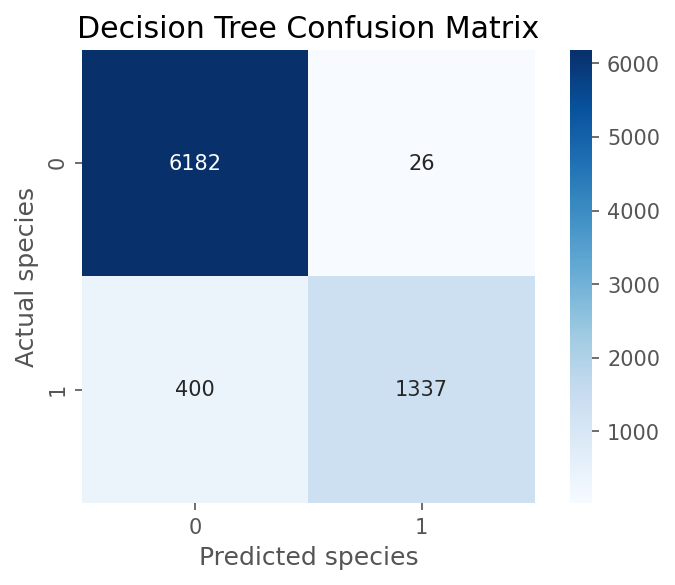

In [58]:
# Print confusion matrix for logistic regression
rf_confusion = confusion_matrix(label_test, randomforest.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Decision Tree Confusion Matrix');

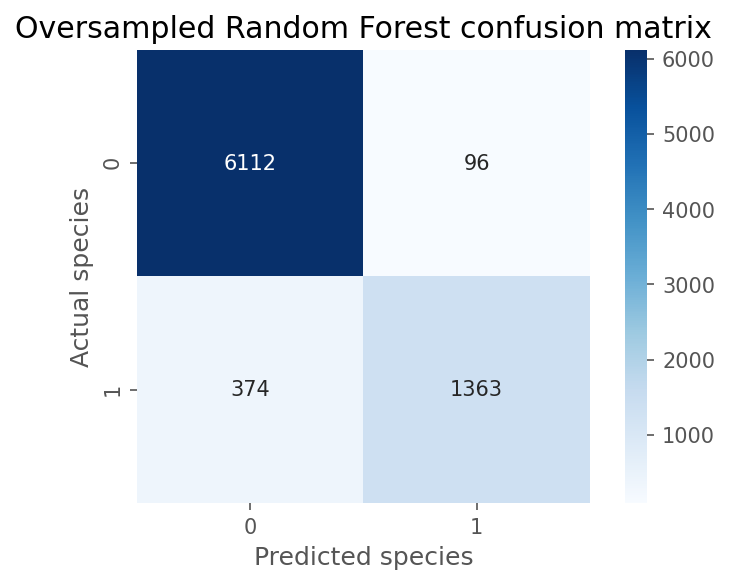

In [59]:
# Run the analysis again. What do we expect to see with balanced classes??
# cell takes ~15s to run
rf_resampled = RandomForestClassifier(n_estimators=100)
clf_ros = rf_resampled.fit(X_resampled, y_resampled)

# Print confusion matrix for kNN regression
rf_resampled_confusion = confusion_matrix(label_test, rf_resampled.predict(X_test_combined))
plt.figure(dpi=150)
sns.heatmap(rf_resampled_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='.0f',
           xticklabels=[0, 1],
           yticklabels=[0, 1])

plt.xlabel('Predicted species')
plt.ylabel('Actual species')
plt.title('Oversampled Random Forest confusion matrix');

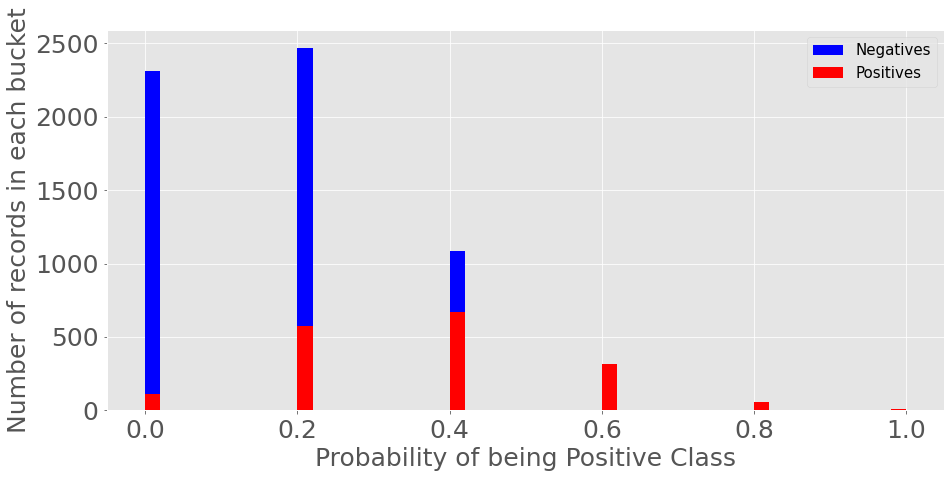

In [60]:
prediction = knn.predict_proba(X_test_combined)[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[label_test==0], bins=50, label='Negatives', color='b')
plt.hist(prediction[label_test==1], bins=50, label='Positives', color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

## Compare Models
Evaluate the RMSE of various models used.

In [82]:
def rmse(actuals, preds):
    '''
    Function to calculate Root Mean Squared Error
    '''
    return np.sqrt(((actuals - preds) ** 2).mean())

In [83]:
models = ['kNN', 'LogisticRegression', 'DecisionTree', 'RandomForest', 'XGBoost']
for key in models.items():
    print("RMSE for {}: {}\n".format(key, rmse(key.predict(X_test_combined), label_test)))

AttributeError: 'tuple' object has no attribute 'predict'

/Users/willnobles/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


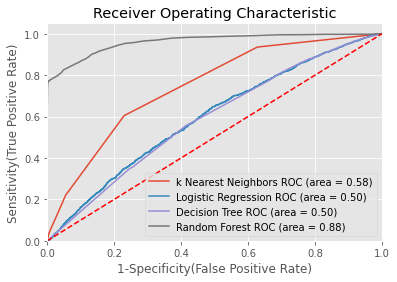

In [66]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'k Nearest Neighbors',
    'model': KNeighborsClassifier(n_neighbors=5),
},
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(C=0.95),
},
{
    'label': 'Decision Tree',
    'model': DecisionTreeClassifier(max_depth=4),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(n_estimators=100),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_combined, label_train) # train the model
    y_pred = model.predict(X_test_combined) # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(label_test, model.predict_proba(X_test_combined)[:,1])
    # Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(label_test, model.predict(X_test_combined))
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

/Users/willnobles/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


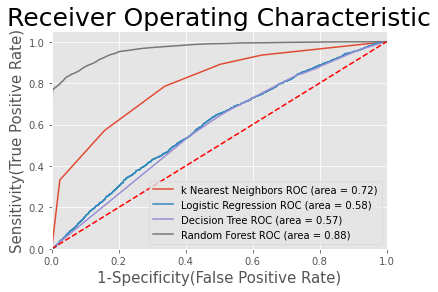

In [170]:
plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'k Nearest Neighbors',
    'model': KNeighborsClassifier(n_neighbors=5),
},
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(C=0.95),
},
{
    'label': 'Decision Tree',
    'model': DecisionTreeClassifier(max_depth=4),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(n_estimators=100),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_resampled, y_resampled) # train the model
    y_pred = model.predict(X_test_combined) # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(label_test, model.predict_proba(X_test_combined)[:,1])
    # Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(label_test, model.predict(X_test_combined))
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)', fontsize=15)
plt.ylabel('Sensitivity(True Positive Rate)', fontsize=15)
plt.title('Receiver Operating Characteristic', fontsize=25)
plt.legend(loc="lower right")
plt.show()   # Display